# PolyaStrength predictions

**Purpose**: To investigate the distribution of observed isoform ratios and PolyaStrength scores based on the polyA site location.


In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%run -i notebook_setup.py

## IMPORTS AND SETUP

In [4]:
PROJECT   = "/projects/b1080/eks/polyadenylation/yeast/"
OUTDIR    = os.path.join(PROJECT, 'manuscript', 'analysis', 'polyastrength_predictions')
RESOURCES = os.path.join(os.path.dirname(OUTDIR), 'resources')
os.makedirs(OUTDIR, exist_ok = True)


# ANALYSIS

### Prepare polyA site data

#### Load information for polyA sites with PolyaStrength predictions

In [5]:
sites_data = pd.read_csv(os.path.join(RESOURCES, 'scer_clustered_sites.polya_comprehensive.txt'), sep = "\t")

sites_data['chrom']  = sites_data['key'].str.split(":").str[0].astype(str)
sites_data['start']  = sites_data['key'].str.split(":").str[1].astype(int)
sites_data['end']    = sites_data['start']+1
sites_data['strand'] = sites_data['key'].str.split(":").str[2].astype(str)

print(sites_data.shape)
print(sites_data['feature'].value_counts())


(30931, 17)
utr3_extended    14611
coding_exon       8338
utr3              6884
utr5              1070
intron              28
Name: feature, dtype: int64


#### Categorize sites based on relative position in the 3'UTR

In [6]:
sites_dict = {}

for i,row in tqdm.tqdm(sites_data.iterrows()):
    
    if (row['feature'] in ['utr3','utr3_extended']):

        rowkey = (row['gene'],row['chrom'],row['strand'])

        if not (rowkey in sites_dict):
            sites_dict[rowkey] = [row['start']]
        else:
            sites_dict[rowkey].append(row['start'])


30931it [00:03, 9639.25it/s]


In [7]:
sites_dict_labels = {}

for rk,pl in sites_dict.items():
    
    sites_dict_labels[rk] = {}
    
    if (len(pl) == 1):
        sites_dict_labels[rk][pl[0]] = 'single'
        
    else:
        spl = sorted(pl)
        g,c,s = rk
            
        sites_dict_labels[rk][spl[0]] = 'first' if (s == '+') else 'last'
        sites_dict_labels[rk][spl[-1]] = 'last' if (s == '+') else 'first'

        for p in spl[1:-1]:
            sites_dict_labels[rk][p] = 'middle'


In [8]:
sites_data['position'] = sites_data.apply(lambda row : sites_dict_labels.get((row['gene'],row['chrom'],row['strand']), {}).get(row['start'], np.nan), axis = 1)

sites_data.loc[sites_data['feature'] == 'coding_exon', 'position'] = 'CDS'
sites_data.loc[sites_data['feature'] == 'intron',      'position'] = 'intron'
sites_data.loc[sites_data['feature'] == 'utr5',        'position'] = 'utr5'
sites_data.loc[sites_data['feature'] == 'intergenic',  'position'] = 'intergenic'

print(sites_data['position'].value_counts())
print(sites_data['position'].isna().sum())


middle    11127
CDS        8338
last       4910
first      4910
utr5       1070
single      548
intron       28
Name: position, dtype: int64
0


### Usage of sites by relative position

(29833, 18)


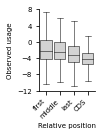


Corresponding statistics for observed usage-
	Kruskal-Wallis test (all groups):	264.220 4.22E-58
	Wilcoxon rank sum test (first vs middle):	  4.420 9.86E-06
	Wilcoxon rank sum test (first vs last)  :	 14.676 9.22E-49
	Wilcoxon rank sum test (middle vs last) :	 13.926 4.37E-44

Summary data-
            count      mean       std        min       25%       50%  \
position                                                               
first      4910.0 -1.829374  3.144372 -11.613792 -4.266786 -2.218522   
middle    11127.0 -2.152916  2.771510 -10.770863 -4.253770 -2.390229   
last       4910.0 -2.762008  3.011618 -11.462870 -4.979281 -3.197468   
CDS        7329.0 -3.448089  4.316590 -11.461574 -5.467000 -4.285713   

               75%        max  
position                       
first     0.422546  10.841652  
middle   -0.145071   7.690607  
last     -0.904050   9.772423  
CDS      -2.729209  19.931567  

Median by group-
position
first    -2.218522
middle   -2.390229
last     -3.19746

In [9]:
fig,ax = plt.subplots(1,1, figsize = (1,1.5))

plot_data = sites_data.loc[sites_data['position'].isin(['CDS','single','first','middle','last'])]
print(plot_data.shape)

x = 'position'
y = 'raw_denom_logit'

sns.boxplot(data = plot_data, x = x, y = y,
            order = ['first','middle','last','CDS'], color = 'lightgray', 
            boxprops = {'edgecolor' : 'black', 'linewidth' : 0.5},
            medianprops = {'color' : 'black', 'linewidth' : 0.5},
            whiskerprops = {'color' : 'black', 'linewidth' : 0.5},
            capprops = {'color' : 'black', 'linewidth' : 0.5},
            flierprops = {'color' : 'black'},
            ax = ax, showfliers = False)

ax.set_xlabel("Relative position")
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = 'right', va = 'top')

ax.set_ylim(-12,8)
ax.yaxis.set_major_locator(MultipleLocator(4))
ax.set_ylabel("Observed usage")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'relative_position.boxplot.score_logit.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print(f"\nCorresponding statistics for observed usage-")

stat, pval = st.kruskal(*[plot_data.loc[plot_data[x] == p, y] for p in ['first','middle','last']])
print(f"\tKruskal-Wallis test (all groups):\t{stat:7.03f} {pval:8.02E}")

stat, pval = st.ranksums(plot_data.loc[plot_data[x] == 'first',  y],
                         plot_data.loc[plot_data[x] == 'middle', y])
print(f"\tWilcoxon rank sum test (first vs middle):\t{stat:7.03f} {pval:8.02E}")

stat, pval = st.ranksums(plot_data.loc[plot_data[x] == 'first', y],
                         plot_data.loc[plot_data[x] == 'last',  y])
print(f"\tWilcoxon rank sum test (first vs last)  :\t{stat:7.03f} {pval:8.02E}")

stat, pval = st.ranksums(plot_data.loc[plot_data[x] == 'middle', y],
                         plot_data.loc[plot_data[x] == 'last',   y])
print(f"\tWilcoxon rank sum test (middle vs last) :\t{stat:7.03f} {pval:8.02E}")


print("\nSummary data-")
print(plot_data.groupby(x)[y].describe().loc[['first','middle','last','CDS']])


print("\nMedian by group-")
print(plot_data.groupby(x)[y].agg('median').loc[['first','middle','last','CDS']])


### PolyaStrength of sites by relative position

(29833, 18)


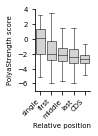


Corresponding statistics for observed usage-
	Kruskal-Wallis test (all groups):	262.519 9.88E-58
	Wilcoxon rank sum test (first vs middle):	  9.707 2.81E-22
	Wilcoxon rank sum test (first vs last)  :	 15.493 3.85E-54
	Wilcoxon rank sum test (middle vs last) :	 10.111 4.91E-24

Summary data-
            count      mean       std       min       25%       50%       75%  \
position                                                                        
single      548.0 -0.324786  1.980127 -5.110386 -2.047537  0.051384  1.366605   
first      4910.0 -1.613497  1.725202 -5.959255 -2.899940 -1.987804 -0.335669   
middle    11127.0 -1.946082  1.464243 -6.552932 -2.971456 -2.201232 -1.170351   
last       4910.0 -2.146848  1.618272 -6.456316 -3.230993 -2.440854 -1.374091   
CDS        8338.0 -2.629469  1.039233 -6.436704 -3.260376 -2.748093 -2.218592   

               max  
position            
single    3.278462  
first     3.484351  
middle    3.540555  
last      3.494534  
CDS       2.1

In [10]:
fig,ax = plt.subplots(1,1, figsize = (1,1.5))

plot_data = sites_data.loc[sites_data['position'].isin(['CDS','single','first','middle','last'])]
print(plot_data.shape)

x = 'position'
y = 'pred_logit'

sns.boxplot(data = plot_data, x = x, y = y,
            order = ['single','first','middle','last','CDS'], color = 'lightgray', 
            boxprops = {'edgecolor' : 'black', 'linewidth' : 0.5},
            medianprops = {'color' : 'black', 'linewidth' : 0.5},
            whiskerprops = {'color' : 'black', 'linewidth' : 0.5},
            capprops = {'color' : 'black', 'linewidth' : 0.5},
            flierprops = {'color' : 'black'},
            ax = ax, showfliers = False)

ax.set_xlabel("Relative position")
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = 'right', va = 'top')

ax.set_ylim(-7,4)
ax.yaxis.set_major_locator(MultipleLocator(2))
ax.set_ylabel("PolyaStrength score")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'relative_position.boxplot.pred_logit.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print(f"\nCorresponding statistics for observed usage-")

stat, pval = st.kruskal(*[plot_data.loc[plot_data[x] == p, y] for p in ['first','middle','last']])
print(f"\tKruskal-Wallis test (all groups):\t{stat:7.03f} {pval:8.02E}")

stat, pval = st.ranksums(plot_data.loc[plot_data[x] == 'first',  y],
                         plot_data.loc[plot_data[x] == 'middle', y])
print(f"\tWilcoxon rank sum test (first vs middle):\t{stat:7.03f} {pval:8.02E}")

stat, pval = st.ranksums(plot_data.loc[plot_data[x] == 'first', y],
                         plot_data.loc[plot_data[x] == 'last',  y])
print(f"\tWilcoxon rank sum test (first vs last)  :\t{stat:7.03f} {pval:8.02E}")

stat, pval = st.ranksums(plot_data.loc[plot_data[x] == 'middle', y],
                         plot_data.loc[plot_data[x] == 'last',   y])
print(f"\tWilcoxon rank sum test (middle vs last) :\t{stat:7.03f} {pval:8.02E}")


print("\nSummary data-")
print(plot_data.groupby(x)[y].describe().loc[['single','first','middle','last','CDS']])


print("\nMedian by group-")
print(plot_data.groupby(x)[y].agg('median').loc[['single','first','middle','last','CDS']])
